# Referecne

* API Tutorial: https://github.com/onnx/tutorials
* Convert TensorFlow models to ONNX: https://github.com/onnx/tensorflow-onnx
* Tensorflow Backend and Frontend for ONNX: https://github.com/onnx/onnx-tensorflow

# Onnx Preparation

In [1]:
!pip install onnx-tf
!pip install tf2onnx

You are using pip version 18.0, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 18.0, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
import onnx
import onnx_tf
import tf2onnx
import os
import sys
import tensorflow as tf
import cv2
import numpy as np
import json
import codecs
from collections import OrderedDict
import matplotlib.pyplot as plt
from PIL import Image

!pip list | grep 'onnx'
!pip list | grep 'onnx-tf'
!pip list | grep 'tf2onnx'
!pip list | grep 'tensorflow'
!pip list | grep 'opencv-python'
!pip list | grep 'numpy'
!pip list | grep 'matplotlib'

onnx                1.3.0                 
onnx-tf             1.2.0                 
tf2onnx             0.3.1                 
You are using pip version 18.0, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
onnx-tf             1.2.0                 
You are using pip version 18.0, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
tf2onnx             0.3.1                 
You are using pip version 18.0, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
tensorflow          1.11.0                
You are using pip version 18.0, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
opencv-python       3.4.3.18              
You are using pip version 18.0, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip

# Tensorflow

Here we use a classification model as the example (https://storage.googleapis.com/download.tensorflow.org/models/mobilenet_v1_1.0_224_frozen.tgz). About how to generate a frozen model, please refer to `freeze_graph.py`.

```sh
python freeze_graph.py \
    --input_graph output/graph.pbtxt \
    --input_checkpoint ./output-16640 \
    --output_graph /tmp/out \
    --output_node_names <name>
```

In [3]:
frozen_model_path = '/notebooks/Google_Drive_Devops_Sync/sophia/tmp/mobilenet_v1_1.0_224/frozen_graph.pb'
label_path = '/notebooks/Google_Drive_Devops_Sync/sophia/tmp/mobilenet_v1_1.0_224/labels.txt'

assert os.path.exists(frozen_model_path), "Tensorflow frozen model does not exist."
assert os.path.exists(label_path), "Label file does not exist."

## Load the graph

In [4]:
detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(frozen_model_path, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')

## Show all operations

In [5]:
def show_operation_names(graph, count=10):
    with graph.as_default():
        with tf.Session() as sess:
            opts = tf.get_default_graph().get_operations()
            for opt in opts[:count]: 
                for output in opt.outputs: print(output.name)
            print("...")
            for opt in opts[-count:]: 
                for output in opt.outputs: print(output.name)
                    
show_operation_names(detection_graph, 5)

input:0
MobilenetV1/Conv2d_0/weights:0
MobilenetV1/Conv2d_0/weights/read:0
MobilenetV1/MobilenetV1/Conv2d_0/convolution:0
MobilenetV1/Conv2d_0/BatchNorm/beta:0
...
MobilenetV1/Predictions/Reshape/shape:0
MobilenetV1/Predictions/Reshape:0
MobilenetV1/Predictions/Softmax:0
MobilenetV1/Predictions/Shape:0
MobilenetV1/Predictions/Reshape_1:0


## Load Label

In [6]:
def loadLabel(labelPath):
    tmp = []
    labels = OrderedDict()
    with codecs.open(labelPath,"r","utf-8") as fin:
        for line in fin:
            tmp = line.strip().split(':')
            labels[tmp[0]] = tmp[1]
    return labels

In [7]:
labels = loadLabel(label_path)
[(str(label) + ":" + labels[str(label)]) for label in range(10)]

['0:background',
 '1:tench, Tinca tinca',
 '2:goldfish, Carassius auratus',
 '3:great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias',
 '4:tiger shark, Galeocerdo cuvieri',
 '5:hammerhead, hammerhead shark',
 '6:electric ray, crampfish, numbfish, torpedo',
 '7:stingray',
 '8:cock',
 '9:hen']

## Inference

In [8]:
def inference_single_image(image, graph):
    with graph.as_default():
        with tf.Session() as sess:
            # handle input and output tensor
            opts = tf.get_default_graph().get_operations()
            all_tensorflow_names = { output.name for opt in opts for output in opt.outputs }
            tensor_dict = {}
            for key in ['MobilenetV1/Predictions/Reshape_1']:
                tensor_name = key + ':0'
                if tensor_name in all_tensorflow_names:
                    tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(tensor_name)
                    
            # run for single image            
            # input
            image_tensor = tf.get_default_graph().get_tensor_by_name('input:0')
            
            # inference
            output_dict = sess.run(tensor_dict, feed_dict={image_tensor: np.expand_dims(image, 0)})
            
            # convert data type float32 to appropriate
            output_dict['MobilenetV1/Predictions/Reshape_1'] = output_dict['MobilenetV1/Predictions/Reshape_1']
            
        return output_dict

In [9]:
def single_image(imagePath):
    image_path = imagePath
    if not os.path.exists(image_path): raise FileNotFoundError("{} not found.".format(image_path))
        
    image = cv2.imread(image_path)
    image = cv2.resize(image, (224, 224), interpolation=cv2.INTER_CUBIC)
    image = image[:,:,::-1]
    plt.imshow(image)
    output_dict = inference_single_image(image, detection_graph)
    
    return output_dict

{'MobilenetV1/Predictions/Reshape_1': array([[6.3376952e-08, 6.5560037e-08, 7.5222251e-06, ..., 5.2390061e-07,
        5.1569474e-05, 5.3490563e-05]], dtype=float32)}
795 0.39241496 shower curtain


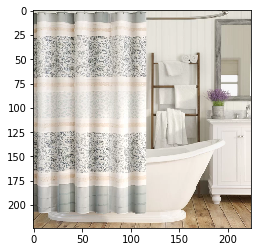

In [10]:
#image_path = '/Users/jiankaiwang/devops/Fruit_Recognition/eval/qnap_fruit_val_00003.JPEG'
image_path = '/notebooks/Google_Drive_Devops_Sync/sophia/tmp/mobilenet_v1_1.0_224/test.jpg'
output_dict = single_image(image_path)
print(output_dict)

cls_idx = int(np.argmax(output_dict['MobilenetV1/Predictions/Reshape_1'], axis=1))
print(cls_idx, output_dict['MobilenetV1/Predictions/Reshape_1'][0][cls_idx], labels[str(cls_idx)])

In [11]:
r, c = np.where(output_dict['MobilenetV1/Predictions/Reshape_1'] > 0.05)
for idx in range(len(r)):
    print(output_dict['MobilenetV1/Predictions/Reshape_1'][r[idx]][c[idx]], labels[str(c[idx])])

0.16483758 digital clock
0.27690268 fire screen, fireguard
0.39241496 shower curtain


# Tensorflow to Onnx

In [11]:
from onnx_tf.frontend import tensorflow_graph_to_onnx_model

In [14]:
with tf.gfile.GFile(frozen_model_path, "rb") as f:
    graph_def = tf.GraphDef()
    graph_def.ParseFromString(f.read())
    
    # ignore_unimplemented: onnx did't implementation the whole tensorflow operations
    onnx_model = tensorflow_graph_to_onnx_model(graph_def, \
                                                "MobilenetV1/Predictions/Softmax", \
                                                ignore_unimplemented=True, \
                                                opset=0)

    with open("/notebooks/Google_Drive_Devops_Sync/sophia/tmp/mobilenet_v1_1.0_224/mobilenet.onnx", "wb") as fout:
        fout.write(onnx_model.SerializeToString())

/usr/local/lib/python3.5/dist-packages/onnx_tf/handlers/handler.py:35: UserWarning: Pack doesn't have ONNX_OP. Please use Handler.onnx_op decorator to register ONNX_OP.
  cls.__name__))
/usr/local/lib/python3.5/dist-packages/onnx_tf/common/handler_helper.py:38: UserWarning: Unknown op Undefined in domain `ai.onnx`. Can't check specification by ONNX. Please set should_check flag to False when call make_node method in handler.
  "ai.onnx"))
/usr/local/lib/python3.5/dist-packages/onnx_tf/handlers/handler.py:35: UserWarning: Unpack doesn't have ONNX_OP. Please use Handler.onnx_op decorator to register ONNX_OP.
  cls.__name__))
/usr/local/lib/python3.5/dist-packages/onnx_tf/common/exception.py:15: UserWarning: Rsqrt is not implemented.
  self._func(self.get_message(*args, **kwargs))
/usr/local/lib/python3.5/dist-packages/onnx_tf/handlers/frontend_handler.py:106: UserWarning: Skipped check for Rsqrt.
  warnings.warn("Skipped check for {}.".format(node.op_type))
/usr/local/lib/python3.5/dist-

In the above warning message, opts `Rsqrt`, `Relu6`, `DepthwiseConv2dNative`, ... are not implemented by onnx so that the onnx model would loss the corresponding operations even if it is transformed. In onnx community, they don't plan to implement all of them because of too many operations in tensorflow.

# Inference from ONNX model

Here we use the onnx official model downloaded from https://github.com/onnx/models/tree/master/models/image_classification/mobilenet. Convert it and infer a image.

In [14]:
from onnx_tf.backend import prepare

In [15]:
onnx_model_path = '/notebooks/Google_Drive_Devops_Sync/sophia/tmp/mobilenetv2-1.0/mobilenetv2-1.0.onnx'
assert os.path.exists(onnx_model_path), "ONNX model is not found."
model = onnx.load(onnx_model_path) # Load the ONNX file
tf_rep = prepare(model) # Import the ONNX model to Tensorflow

/usr/local/lib/python3.5/dist-packages/onnx_tf/common/handler_helper.py:74: UserWarning: Unknown op ConstantLike in domain `ai.onnx`.
  handler.ONNX_OP, handler.DOMAIN or "ai.onnx"))
/usr/local/lib/python3.5/dist-packages/onnx_tf/common/handler_helper.py:71: UserWarning: Fail to get since_version of Expand in domain `` with max_inclusive_version=7. Set to 1.
  handler.ONNX_OP, handler.DOMAIN, version))


Instructions for updating:
keep_dims is deprecated, use keepdims instead


Instructions for updating:
keep_dims is deprecated, use keepdims instead


## Show all operations

In [16]:
print(tf_rep.inputs) # Input nodes to the model
print('-----')
print(tf_rep.outputs) # Output nodes from the model
print('-----')
print(tf_rep.tensor_dict) # All nodes in the model

['data']
-----
['mobilenetv20_output_flatten0_reshape0']
-----
{'mobilenetv20_features_linearbottleneck12_elemwise_add0': <tf.Tensor 'mobilenetv20_features_linearbottleneck12_elemwise_add0:0' shape=(1, 96, 14, 14) dtype=float32>, 'mobilenetv20_features_linearbottleneck16_relu0_fwd': <tf.Tensor 'mobilenetv20_features_linearbottleneck16_relu0_fwd:0' shape=(1, 960, 7, 7) dtype=float32>, 'mobilenetv20_features_linearbottleneck2_conv2_fwd': <tf.Tensor 'transpose_29:0' shape=(1, 24, 56, 56) dtype=float32>, 'mobilenetv20_features_linearbottleneck11_elemwise_add0': <tf.Tensor 'mobilenetv20_features_linearbottleneck11_elemwise_add0:0' shape=(1, 96, 14, 14) dtype=float32>, 'mobilenetv20_features_linearbottleneck0_batchnorm2_beta': <tf.Tensor 'Const_17:0' shape=(16,) dtype=float32>, 'mobilenetv20_features_linearbottleneck0_conv0_weight': <tf.Tensor 'Const_5:0' shape=(32, 32, 1, 1) dtype=float32>, 'mobilenetv20_features_linearbottleneck10_conv2_weight': <tf.Tensor 'Const_165:0' shape=(96, 384, 1, 

In [17]:
from IPython.display import display

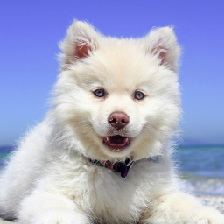

(1, 3, 224, 224)


In [20]:
test_img = "/notebooks/Google_Drive_Devops_Sync/sophia/tmp/mobilenetv2-1.0/test.png"
assert os.path.exists(test_img), "Test image is not found."

img = Image.open(test_img).resize((224, 224))
display(img)
img = np.asarray(img)
img = np.swapaxes(img, 1, 2)
img = np.swapaxes(img, 0, 1)
img = img.reshape(1, 3, 224, 224)   # in order to meet the requirement of input's shape
print(img.shape)

In [21]:
output_cls = tf_rep.run(img)
print(output_cls["mobilenetv20_output_flatten0_reshape0"].shape)

(1, 1000)


In [22]:
output_cls_idx = np.argmax(output_cls["mobilenetv20_output_flatten0_reshape0"], axis=1)
print(output_cls_idx)
print(output_cls["mobilenetv20_output_flatten0_reshape0"][0][output_cls_idx])

[470]
[185.9536]


# Onnx to Tensorflow

In [23]:
import onnx
from onnx_tf.backend import prepare

def onnx2pb(onnx_input_path, pb_output_path):
    onnx_model = onnx.load(onnx_input_path)  # load onnx model
    tf_exp = prepare(onnx_model)  # prepare tf representation
    tf_exp.export_graph(pb_output_path)  # export the model

In [24]:
onnx_input_path = '/notebooks/Google_Drive_Devops_Sync/sophia/tmp/mobilenetv2-1.0/mobilenetv2-1.0.onnx'
pb_output_path = '/notebooks/Google_Drive_Devops_Sync/sophia/tmp/mobilenetv2-1.0/mobilenetv2-1.0.pb'

onnx2pb(onnx_input_path, pb_output_path)

/usr/local/lib/python3.5/dist-packages/onnx_tf/common/handler_helper.py:74: UserWarning: Unknown op ConstantLike in domain `ai.onnx`.
  handler.ONNX_OP, handler.DOMAIN or "ai.onnx"))
/usr/local/lib/python3.5/dist-packages/onnx_tf/common/handler_helper.py:71: UserWarning: Fail to get since_version of Expand in domain `` with max_inclusive_version=7. Set to 1.
  handler.ONNX_OP, handler.DOMAIN, version))


## Test PB model from onnx

In [25]:
onnx_pb_graph = tf.Graph()
with onnx_pb_graph.as_default():
    onnx_pb_graph_def = tf.GraphDef()
    with tf.gfile.GFile(pb_output_path, 'rb') as fid:
        serialized_graph = fid.read()
        onnx_pb_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(onnx_pb_graph_def, name='')

In [26]:
show_operation_names(onnx_pb_graph, 5)

Const:0
Const_1:0
Const_2:0
Const_3:0
Const_4:0
...
Cast:0
SparseToDense/default_value:0
SparseToDense:0
add:0
mobilenetv20_output_flatten0_reshape0:0


In [27]:
def general_inference_single_image(image, graph, input_layer="input:0", output_layer=['MobilenetV1/Predictions/Reshape_1']):
    with graph.as_default():
        with tf.Session() as sess:
            # handle input and output tensor
            opts = tf.get_default_graph().get_operations()
            all_tensorflow_names = { output.name for opt in opts for output in opt.outputs }
            tensor_dict = {}
            for key in output_layer:
                tensor_name = key + ':0'
                if tensor_name in all_tensorflow_names:
                    tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(tensor_name)
                    
            assert len(tensor_dict.keys()) > 0, "No output layer is found."
                    
            # run for single image            
            # input
            image_tensor = tf.get_default_graph().get_tensor_by_name(input_layer)
            
            # inference
            output_dict = sess.run(tensor_dict, feed_dict={image_tensor: np.expand_dims(image, 0)})
            
        return output_dict

In [28]:
def single_image(imagePath, used_graph, input_layer, output_layer):
    image_path = imagePath
    if not os.path.exists(image_path): raise FileNotFoundError("{} not found.".format(image_path))
        
    image = cv2.imread(image_path)
    image = cv2.resize(image, (224, 224), interpolation=cv2.INTER_CUBIC)
    image = image[:,:,::-1]
    plt.imshow(image)
    print(image.shape)
    image = np.swapaxes(image, 1, 2)
    image = np.swapaxes(image, 0, 1)
    image = image.reshape(3, 224, 224)
    print(image.shape)
    output_dict = general_inference_single_image(image, used_graph, input_layer, output_layer)
    
    return output_dict

(224, 224, 3)
(3, 224, 224)


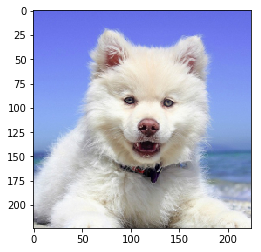

In [29]:
onnx_pb_output_dict = single_image(test_img, onnx_pb_graph, "data:0", ["mobilenetv20_output_flatten0_reshape0"])

In [30]:
print(onnx_pb_output_dict["mobilenetv20_output_flatten0_reshape0"].shape)
onnx_pb_output_dict_idx = np.argmax(onnx_pb_output_dict["mobilenetv20_output_flatten0_reshape0"], axis=1)
print(onnx_pb_output_dict_idx)
print(onnx_pb_output_dict["mobilenetv20_output_flatten0_reshape0"][0][onnx_pb_output_dict_idx])

(1, 1000)
[470]
[185.9536]
